### Accumulator

### 1. Implied Vol Estimation

In [1]:
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np

# Black-Scholes formula for a European call option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Objective function to find implied volatility
def implied_volatility_call(S, K, T, r, market_price):
    def objective_function(sigma):
        return black_scholes_call(S, K, T, r, sigma) - market_price

    # Use a root-finding method to solve for implied volatility
    try:
        implied_vol = brentq(objective_function, 1e-4, 5)  # Bounds for sigma: [0.0001, 5]
        return implied_vol
    except ValueError:
        return np.nan  # Return NaN if no solution is found


In [2]:
# AMZN parameters
S = 220.52  # Current stock price
K = 220  # Strike price
T = 1  # Time to maturity in years
r = 0.043  # Risk-free rate
market_price = 34.13  # Observed market price of the call option

# Estimate implied volatility
AMZN_vol = implied_volatility_call(S, K, T, r, market_price)
print(f"AMZN 1 year ATM Call Implied Volatility: {AMZN_vol:.4f}")

AMZN 1 year ATM Call Implied Volatility: 0.3385


In [3]:
# AAPL parameters
S = 248.05  # Current stock price
K = 250  # Strike price
T = 1  # Time to maturity in years
r = 0.043  # Risk-free rate
market_price = 28.5  # Observed market price of the call option

# Estimate implied volatility
AAPL_vol = implied_volatility_call(S, K, T, r, market_price)
print(f"AAPL 1 year ATM Call Implied Volatility: {AAPL_vol:.4f}")

AAPL 1 year ATM Call Implied Volatility: 0.2471


In [4]:
# META parameters
S = 597.19  # Current stock price
K = 600  # Strike price
T = 1  # Time to maturity in years
r = 0.043  # Risk-free rate
market_price = 97.3  # Observed market price of the call option

# Estimate implied volatility
META_vol = implied_volatility_call(S, K, T, r, market_price)
print(f"META 1 year ATM Call Implied Volatility: {META_vol:.4f}")

META 1 year ATM Call Implied Volatility: 0.3683


/Users/ianz/anaconda3/lib/python3.11/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


Correlation Matrix:
Ticker      AAPL      AMZN      META
Ticker                              
AAPL    1.000000  0.619072  0.591930
AMZN    0.619072  1.000000  0.613559
META    0.591930  0.613559  1.000000


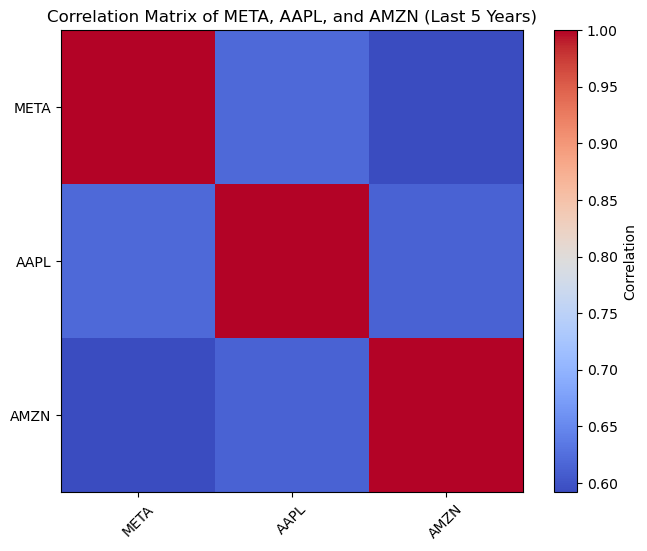

Fisher Transformed Correlation Matrix:
Ticker      AAPL      AMZN      META
Ticker                              
AAPL         inf  0.723498  0.680632
AMZN    0.723498       inf  0.714610
META    0.680632  0.714610       inf
Standard Error of Fisher Estimates: 0.0282
95% Confidence Interval for Fisher Transformed Values:
Lower Bound (Fisher):
Ticker      AAPL      AMZN      META
Ticker                              
AAPL         inf  0.668150  0.625283
AMZN    0.668150       inf  0.659261
META    0.625283  0.659261       inf
Upper Bound (Fisher):
Ticker      AAPL      AMZN      META
Ticker                              
AAPL         inf  0.778847  0.735980
AMZN    0.778847       inf  0.769958
META    0.735980  0.769958       inf
95% Confidence Interval for Correlations:
Lower Bound:
Ticker      AAPL      AMZN      META
Ticker                              
AAPL    1.000000  0.583761  0.554796
AMZN    0.583761  1.000000  0.577871
META    0.554796  0.577871  1.000000
Upper Bound:
Ticker     

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download historical data for 5 years
tickers = ["META", "AAPL", "AMZN"]
start_date = "2019-01-01"
end_date = "2024-01-01"
data = yf.download(tickers, start=start_date, end=end_date, progress=False)["Close"]

# Drop missing values to align data
data = data.dropna()

# Calculate daily returns
returns = data.pct_change().dropna()

# Compute the correlation matrix
correlation_matrix = returns.corr()

print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap="coolwarm", interpolation="none")
plt.colorbar(label="Correlation")
plt.xticks(range(len(tickers)), tickers, rotation=45)
plt.yticks(range(len(tickers)), tickers)
plt.title("Correlation Matrix of META, AAPL, and AMZN (Last 5 Years)")
plt.show()

# Function to calculate Fisher transformation and standard error
def fisher_standard_error(correlation_matrix, sample_size):
    fisher_transformed = 0.5 * np.log((1 + correlation_matrix) / (1 - correlation_matrix))
    standard_error = 1 / np.sqrt(sample_size - 3)  # Standard error of z
    return fisher_transformed, standard_error

# Calculate sample size (number of daily returns)
sample_size = len(returns)

# Compute Fisher-transformed correlation matrix and standard error
fisher_transformed, standard_error = fisher_standard_error(correlation_matrix, sample_size)

# Calculate upper and lower bounds for Fisher-transformed values
fisher_lower_bound = fisher_transformed - 1.96 * standard_error
fisher_upper_bound = fisher_transformed + 1.96 * standard_error

# Back-transform Fisher bounds to correlation space
lower_bound = np.tanh(fisher_lower_bound)
upper_bound = np.tanh(fisher_upper_bound)

# Print results
print("Fisher Transformed Correlation Matrix:")
print(fisher_transformed)
print(f"Standard Error of Fisher Estimates: {standard_error:.4f}")
print("95% Confidence Interval for Fisher Transformed Values:")
print("Lower Bound (Fisher):")
print(fisher_lower_bound)
print("Upper Bound (Fisher):")
print(fisher_upper_bound)
print("95% Confidence Interval for Correlations:")
print("Lower Bound:")
print(lower_bound)
print("Upper Bound:")
print(upper_bound)


### 2. Simple Accumulator Pricing and Greeks: Monte Carlo Simulation

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Function to simulate the accumulator price using pre-generated random numbers
def simulate_accumulator_price(S0, strike, barrier, T, r, sigma, num_steps, daily_shares, random_numbers):
    dt = T / num_steps
    final_payoffs = []
    knockouts = 0

    for rand_path in random_numbers:
        stock_prices = [S0]
        total_shares = 0
        knocked_out = False
        payoff = 0

        for step, Z in enumerate(rand_path):
            # Simulate next stock price using GBM
            next_price = stock_prices[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
            stock_prices.append(next_price)

            # Check knock-out condition
            if next_price >= barrier and not knocked_out:
                knocked_out = True
                knockouts += 1

            # Accumulate shares if not knocked out
            if not knocked_out:
                if next_price >= strike:
                    payoff += daily_shares * (stock_prices[-1] - strike) * np.exp(-r * dt * (step+1))
                else:
                    payoff += 2 * daily_shares * (stock_prices[-1] - strike) * np.exp(-r * dt * (step+1))

        # Final payoff at maturity
        final_payoffs.append(payoff)

    # Calculate mean, variance, and other key statistics
    accumulator_price = np.mean(final_payoffs)
    std_dev = np.std(final_payoffs, ddof=1)
    knock_out_rate = knockouts / len(random_numbers)

    return accumulator_price, std_dev, knock_out_rate, final_payoffs

# Confidence interval calculation
def calculate_confidence_interval(payoffs, confidence_level=0.95):
    sample_mean = np.mean(payoffs)
    sample_std_dev = np.std(payoffs, ddof=1)  # Sample standard deviation
    z_value = norm.ppf(0.5 + confidence_level / 2)
    margin_of_error = z_value * sample_std_dev / np.sqrt(len(payoffs))

    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error

    return sample_mean, sample_std_dev, (lower_bound, upper_bound)

# Function to simulate using the Antithetic Variates method
def simulate_with_antithetic(S0, strike, barrier, T, r, sigma, num_steps, daily_shares, random_numbers):
    # Split the random numbers into two halves
    half_size = random_numbers.shape[0] // 2
    random_numbers_first_half = random_numbers[:half_size]
    random_numbers_second_half = -random_numbers[half_size:]

    # Combine original and antithetic random numbers
    combined_random_numbers = np.concatenate((random_numbers_first_half, random_numbers_second_half), axis=0)

    # Perform simulation
    return simulate_accumulator_price(S0, strike, barrier, T, r, sigma, num_steps, daily_shares, combined_random_numbers)
    
# Modify the convergence plot to start from n = 2000
def check_convergence_from_n(simulated_values, start_n=2000):
    cumulative_mean = np.cumsum(simulated_values) / np.arange(1, len(simulated_values) + 1)
    overall_mean = np.mean(simulated_values)
    
    # Plot starting from start_n
    plt.figure(figsize=(10, 6))
    plt.plot(range(start_n, len(cumulative_mean) + 1), cumulative_mean[start_n - 1:], label="Cumulative Mean")
    plt.axhline(y=overall_mean, color='r', linestyle='--', label=f"Overall Mean = {overall_mean:.4f}")
    
    # Add annotation with the mean value
    plt.text(len(simulated_values) * 1.05, overall_mean, f"{overall_mean:.4f}", 
             color='red', va='center', ha='left', backgroundcolor='white')
    
    plt.xlabel('Number of Simulations')
    plt.ylabel('Cumulative Mean')
    plt.title(f'Monte Carlo Convergence of Accumulator Price (Starting from n = {start_n})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Numerical Greeks calculation for a single asset
def calculate_greeks_single_asset(S0, strike, barrier, T, r, sigma, num_steps, daily_shares, random_numbers, epsilon=1e-4):
    # Delta: Sensitivity to initial stock price
    S0_up = S0 + epsilon
    S0_down = S0 - epsilon

    payoff_up, _, _, _ = simulate_accumulator_price(S0_up, strike, barrier, T, r, sigma, num_steps, daily_shares, random_numbers)
    payoff_down, _, _, _ = simulate_accumulator_price(S0_down, strike, barrier, T, r, sigma, num_steps, daily_shares, random_numbers)

    delta = (payoff_up - payoff_down) / (2 * epsilon)

    # Vega: Sensitivity to volatility
    sigma_up = sigma + epsilon
    sigma_down = sigma - epsilon

    payoff_up, _, _, _ = simulate_accumulator_price(S0, strike, barrier, T, r, sigma_up, num_steps, daily_shares, random_numbers)
    payoff_down, _, _, _ = simulate_accumulator_price(S0, strike, barrier, T, r, sigma_down, num_steps, daily_shares, random_numbers)

    vega = (payoff_up - payoff_down) / (2 * epsilon)

    return delta, vega

# Calculate VaR and CVaR
def calculate_var_cvar(payoffs, alpha=0.01):
    sorted_payoffs = np.sort(payoffs)
    var = sorted_payoffs[int(alpha * len(sorted_payoffs))]
    cvar = sorted_payoffs[:int(alpha * len(sorted_payoffs))].mean()
    return var, cvar

Standard Method: Price = -19.7701, Std Dev = 6677.2715, Knock-Out Rate = 55.17%
Confidence Interval (95%): (-61.15545180449136, 21.61534221414917)
1% VaR: -23647.8003, 1% CVaR: -27570.1082
5% VaR: -15016.6596, 5% CVaR: -20331.8307


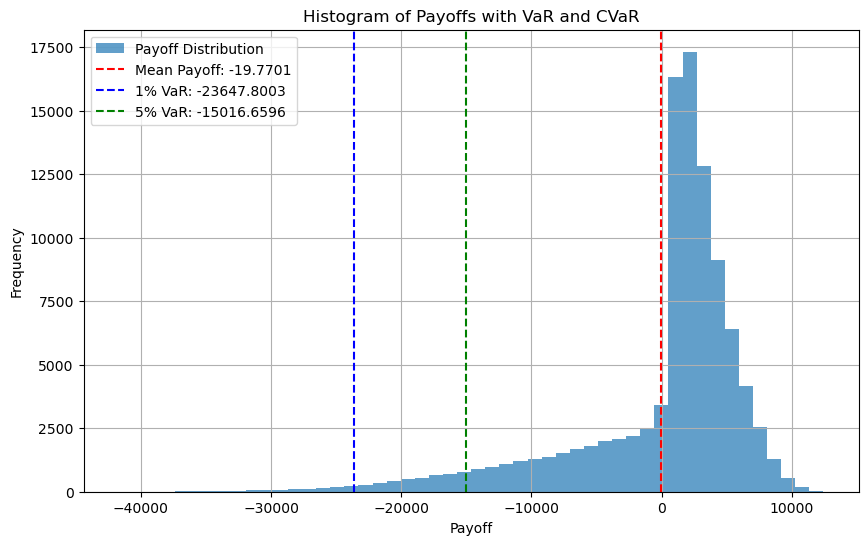

Antithetic Method: Price = -10.2366, Std Dev = 6670.4346, Knock-Out Rate = 55.10%
Confidence Interval (95%): (-51.57965425055119, 31.106390004424355)
1% VaR: -23632.3897, 1% CVaR: -27629.5739
5% VaR: -14917.2301, 5% CVaR: -20318.4539


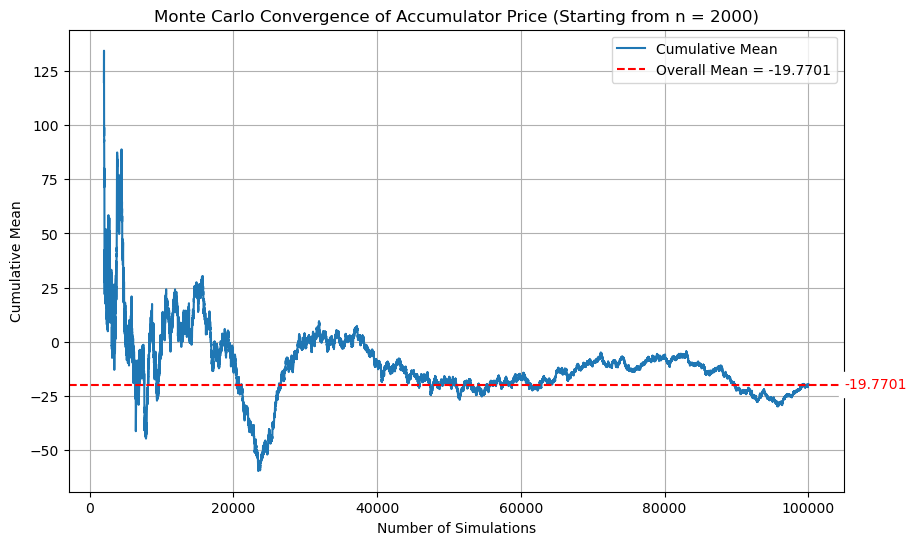

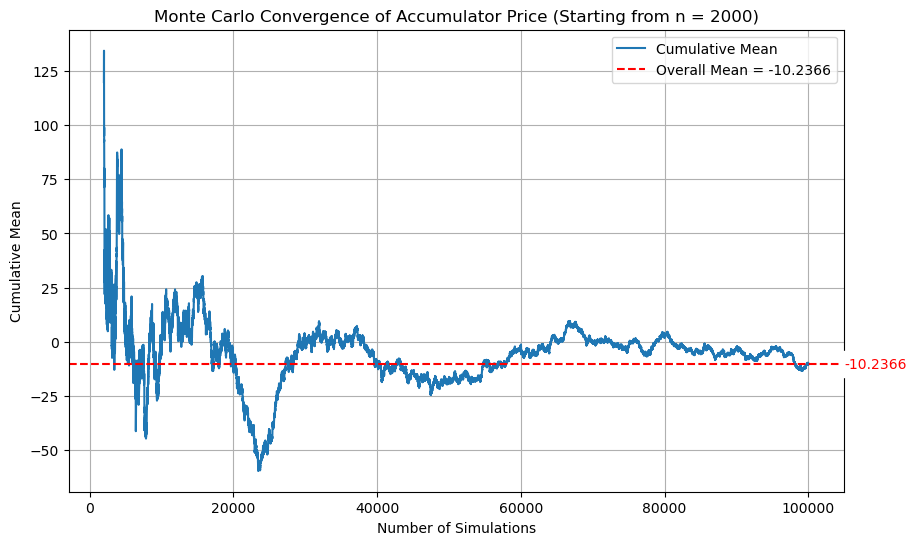

In [7]:
# Parameters for the simulation
S0 = 220.52  # Initial stock price
strike = S0 * 0.8623  # Strike price
barrier = S0 * 1.2  # Knock-out barrier
T = 252 / 252  # Time to maturity in years
r = 0.043  # Risk-free rate
sigma = AMZN_vol  # Volatility
num_steps = 252  # Daily steps
daily_shares = 1  # Shares accumulated daily
num_simulations = 100000  # Number of simulations

# Generate random numbers for both methods
random_numbers = np.random.normal(0, 1, (num_simulations, num_steps))

# Perform simulations
price_standard, std_dev_standard, knock_out_rate_standard, final_payoffs_standard = simulate_accumulator_price(
    S0, strike, barrier, T, r, sigma, num_steps, daily_shares, random_numbers
)

mean_price, std_dev_price, conf_interval = calculate_confidence_interval(final_payoffs_standard)

print(f"Standard Method: Price = {price_standard:.4f}, Std Dev = {std_dev_standard:.4f}, Knock-Out Rate = {knock_out_rate_standard:.2%}")
print(f"Confidence Interval (95%): {conf_interval}")

var_1, cvar_1 = calculate_var_cvar(final_payoffs_standard, alpha=0.01)
var_5, cvar_5 = calculate_var_cvar(final_payoffs_standard, alpha=0.05)

print(f"1% VaR: {var_1:.4f}, 1% CVaR: {cvar_1:.4f}")
print(f"5% VaR: {var_5:.4f}, 5% CVaR: {cvar_5:.4f}")

# Plot histogram of payoffs
plt.figure(figsize=(10, 6))
plt.hist(final_payoffs_standard, bins=50, alpha=0.7, label="Payoff Distribution")
plt.axvline(mean_price, color='r', linestyle='--', label=f"Mean Payoff: {mean_price:.4f}")
plt.axvline(var_1, color='b', linestyle='--', label=f"1% VaR: {var_1:.4f}")
plt.axvline(var_5, color='g', linestyle='--', label=f"5% VaR: {var_5:.4f}")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.title("Histogram of Payoffs with VaR and CVaR")
plt.legend()
plt.grid(True)
plt.show()


# Perform simulation with antithetic variates
price_antithetic, std_dev_antithetic, knock_out_rate_antithetic, final_payoffs_antithetic = simulate_with_antithetic(
    S0, strike, barrier, T, r, sigma, num_steps, daily_shares, random_numbers
)

mean_price_antithetic, std_dev_price_antithetic, conf_interval_antithetic = calculate_confidence_interval(final_payoffs_antithetic)

print(f"Antithetic Method: Price = {price_antithetic:.4f}, Std Dev = {std_dev_antithetic:.4f}, Knock-Out Rate = {knock_out_rate_antithetic:.2%}")
print(f"Confidence Interval (95%): {conf_interval_antithetic}")

var_1_antithetic, cvar_1_antithetic = calculate_var_cvar(final_payoffs_antithetic, alpha=0.01)
var_5_antithetic, cvar_5_antithetic = calculate_var_cvar(final_payoffs_antithetic, alpha=0.05)

print(f"1% VaR: {var_1_antithetic:.4f}, 1% CVaR: {cvar_1_antithetic:.4f}")
print(f"5% VaR: {var_5_antithetic:.4f}, 5% CVaR: {cvar_5_antithetic:.4f}")

# Check convergence from n = 2000
check_convergence_from_n(final_payoffs_standard, start_n=2000)
check_convergence_from_n(final_payoffs_antithetic, start_n=2000)


In [8]:
# Calculate Greeks for the single asset
delta, vega = calculate_greeks_single_asset(S0, strike, barrier, T, r, sigma, num_steps, daily_shares, random_numbers)

# Print Greeks
print("Delta:", delta)
print("Vega:", vega)

Delta: 181.57843526219963
Vega: -27937.34500857722


### 3. Simple Accumulator Pricing and Greeks: Analytical Result

In [10]:
import numpy as np
from scipy.stats import norm

def call_option(S, K, T, r, sigma):
    """
    Pricing the call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    term1 = S * norm.cdf(d1)
    term2 = K * np.exp(-r * T) * norm.cdf(d2)

    return term1 - term2

def put_option(S, K, T, r, sigma):
    """
    Pricing the put option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    term1 = S * norm.cdf(-1*d1)
    term2 = K * np.exp(-r * T) * norm.cdf(-1*d2)

    return term2 - term1

def digital_call(S, K, T, r, sigma):
    """
    Pricing the digital call option.
    """
    d2 = (np.log(S / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    digital_price = np.exp(-r * T) * norm.cdf(d2)
    return digital_price


def barrier_call(S, K, B, T, r, sigma):
    """
    Pricing the up-and-out barrier call option with B>K.
    """
    spread = call_option(S, K, T, r, sigma) - call_option(S, B, T, r, sigma) - (B-K) * digital_call(S, B, T, r, sigma)
    
    reflected_spread = (S/B)**(1-2*r/sigma**2)*(call_option(B**2/S, K, T, r, sigma) - call_option(B**2/S, B, T, r, sigma)- (B-K) * digital_call(B**2/S, B, T, r, sigma))

    return spread - reflected_spread


def barrier_put(S, K, B, T, r, sigma):
    """
    Pricing the up-and-out barrier put option with B>K.
    """
    put = put_option(S, K, T, r, sigma)
    
    reflected_put = (S/B)**(1-2*r/sigma**2)*put_option(B**2/S, K, T, r, sigma)

    return put - reflected_put


def accumulator_price_daily_settlement(S0, K, B, T, r, sigma, num_observations):
    dt = T / num_observations
    price = 0
    for i in range(1, num_observations + 1):
        T_obs = i * dt  # Observation time
        call_price = barrier_call(S0, K, B, T_obs, r, sigma)
        put_price = barrier_put(S0, K, B, T_obs, r, sigma)
        
        # Accumulator involves long one barrier call and short two barrier puts
        price += (call_price - 2 * put_price)

    return price

In [11]:
# Parameters
S0 = 220.52  # Initial stock price
K = S0 * 0.8623  # Strike price
B = S0 * np.exp(0.5826*AMZN_vol*np.sqrt(1/252))*1.2 # Knock-out barrier

T = 252/252  # Time to maturity in years
r = 0.043  # Risk-free rate
sigma = AMZN_vol  # Volatility
num_observations = 252  # Daily observations

# Calculate the price of the accumulator
accumulator_price = accumulator_price_daily_settlement(S0, K, B, T, r, sigma, num_observations)
print(f"Analytical Accumulator Price (daily Settlement): {accumulator_price:.4f}")

Analytical Accumulator Price (daily Settlement): -2.3930


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Function to calculate the PDF and CDF of the standard normal distribution
def pdf(x):
    return norm.pdf(x)

def cdf(x):
    return norm.cdf(x)

# Function to calculate d1 and related variables
def calculate_d_variables(S, K, B, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d1_B = (np.log(S / B) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d1_R = (np.log(B**2 / (S * K)) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d1_BR = (np.log(B / S) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return d1, d1_B, d1_R, d1_BR

# Function to calculate Delta for a single time to maturity
def delta_single_t(S, K, B, T, r, sigma):
    d1, d1_B, d1_R, d1_BR = calculate_d_variables(S, K, B, T, r, sigma)

    delta = (cdf(d1) - cdf(d1_B) - pdf(d1_B) * (1 / (sigma * np.sqrt(T))) +
             (K / B) * pdf(d1_B) * (1 / (sigma * np.sqrt(T))) - (1-2*r/(sigma**2)) * 
             (S/B)**(-2*r/(sigma**2))/B * (B**2/S * cdf(d1_R) - K * np.exp(-r * T) *
                                           cdf(d1_R - sigma*np.sqrt(T)) - B**2/S * cdf(d1_BR) + 
                                           K * np.exp(-r * T) * cdf(d1_BR - sigma*np.sqrt(T))) - 
             (S/B)**(1-2*r/(sigma**2)) * (-1 * (B/S)**2 * cdf(d1_R) + (B/S)**2 * cdf(d1_BR) + 
                                          (B**2/S - K*B/S) * pdf(d1_BR) / (sigma * S * np.sqrt(T))) - 
             2 * (-1 * cdf(-1*d1) - (1-2*r/(sigma**2))*(S/B)**(-2*r/(sigma**2))/B * (K * np.exp(-r * T) * cdf(-1*d1_R+sigma*np.sqrt(T)) - 
                                                                                B**2/S * cdf(-1 * d1_R)) -
                  (S/B)**(1-2*r/(sigma**2)) * (B/S)**2 * cdf(-1*d1_R)))
    return delta

# Function to calculate Vega for a single time to maturity
def vega_single_t(S, K, B, T, r, sigma):
    d1, d1_B, d1_R, d1_BR = calculate_d_variables(S, K, B, T, r, sigma)

    vega = (S * pdf(d1) * np.sqrt(T) - pdf(d1_B) * ((S-S*K/B)*(np.sqrt(T)-d1_B/sigma)+S*K*np.sqrt(T)/B) - 
            4*r*np.log(S/B)*(S/B)**(1-2*r/(sigma**2))/(sigma**3) * (B**2/S*cdf(d1_R) - K*np.exp(-r * T)*cdf(d1_R-sigma*np.sqrt(T)) - 
            B**2/S*cdf(d1_BR) + K*np.exp(-r * T)*cdf(d1_BR-sigma*np.sqrt(T))) - 
            (S/B)**(1-2*r/(sigma**2)) * (B**2/S*pdf(d1_R)*np.sqrt(T) - pdf(d1_BR) * ((B**2/S - B*K/S)*(np.sqrt(T)-d1_BR/sigma)+
            B*K*np.sqrt(T)/S)) - 2 * (S*pdf(d1)*np.sqrt(T) - 
            4*r*np.log(S/B)*(S/B)**(1-2*r/(sigma**2))/(sigma**3) * 
            (K*np.exp(-r*T)*cdf(-1*d1_R+sigma*np.sqrt(T)) - 
            B**2/S * cdf(-1*d1_R)) - 
            (S/B)**(1-2*r/(sigma**2))*B**2/S * pdf(d1_R) * np.sqrt(T))
           )
    return vega

# Function to calculate cumulative Delta and Vega
def delta_analytical(S, K, B, T, r, sigma, num_steps):
    dt = T / num_steps
    delta_sum = 0
    for i in range(1, num_steps + 1):
        delta_sum += delta_single_t(S, K, B, i * dt, r, sigma)
    return delta_sum

def vega_analytical(S, K, B, T, r, sigma, num_steps):
    dt = T / num_steps
    vega_sum = 0
    for i in range(1, num_steps + 1):
        vega_sum += vega_single_t(S, K, B, i * dt, r, sigma)
    return vega_sum

# Parameters
S0 = 220.52  # Initial stock price
K = S0 * 0.8623  # Strike price
B = S0 * np.exp(0.5826*AMZN_vol*np.sqrt(1/252))*1.2 # Knock-out barrier

T = 252/252  # Time to maturity in years
r = 0.043  # Risk-free rate
sigma = AMZN_vol  # Volatility
num_observations = 252  # Daily observations

# Analytical Delta and Vega
analytical_delta = delta_analytical(S0, K, B, T, r, sigma, num_steps)
analytical_vega = vega_analytical(S0, K, B, T, r, sigma, num_steps)

# Print analytical results
print("Analytical Delta:", analytical_delta)
print("Analytical Vega:", analytical_vega)


Analytical Delta: 107.6942877531912
Analytical Vega: -29357.32753464777


### 4. Simple Accumulator: Model Test

In [13]:
# Parameters
S0 = 220.52  # Initial stock price
T = 252 / 252  # Time to maturity in years
r = 0.043  # Risk-free rate
sigma = AMZN_vol  # Volatility
num_steps = 252  # Daily steps
daily_shares = 1  # Shares accumulated daily
num_simulations = 100000  # Number of simulations
random_numbers = np.random.normal(0, 1, (num_simulations, num_steps))
num_observations = 252

ratios = [(0.2,1.2), (0.4,1.2), (0.6,1.2), (0.8,1.2), (1.0, 1.2), (0.8,1.1), (0.8,1.2), (0.8,1.3), (0.8,1.4), (0.8,1.5)]
mc_mean = []
mc_ci = []
analytical_result = []
for K_ratio, B_ratio in ratios:
    # Simulation
    strike = S0 * K_ratio  # Strike price
    barrier = S0 * B_ratio  # Knock-out barrier

    price_standard, std_dev_standard, knock_out_rate_standard, final_payoffs_standard = simulate_accumulator_price(
        S0, strike, barrier, T, r, sigma, num_steps, daily_shares, random_numbers
    )
    mean_price, std_dev_price, conf_interval = calculate_confidence_interval(final_payoffs_standard)
    mc_mean.append(price_standard)
    mc_ci.append(conf_interval)
    
    # Analytical
    K = S0 * K_ratio # Strike price
    B = S0 * np.exp(0.5826*AMZN_vol*np.sqrt(1/252))*B_ratio # Knock-out barrier
    analytical_result.append(accumulator_price_daily_settlement(S0, K, B, T, r, sigma, num_observations))
    
model_test_df = pd.DataFrame({
    'K_ratio, B_ratio': ratios,
    'MC Mean':mc_mean,
    'MC Confidence Interval':mc_ci,
    'Analytical Value':analytical_result
})

print(model_test_df)

  K_ratio, B_ratio       MC Mean                    MC Confidence Interval  \
0       (0.2, 1.2)  24738.636010    (24657.48234311036, 24819.78967689611)   
1       (0.4, 1.2)  17720.070878    (17662.17787906406, 17777.96387784618)   
2       (0.6, 1.2)  10620.386785  (10582.822455635855, 10657.951113896648)   
3       (0.8, 1.2)   2799.764562    (2764.855179174711, 2834.673945350675)   
4       (1.0, 1.2)  -7350.278066  (-7414.796752535322, -7285.759379901364)   
5       (0.8, 1.1)    828.859475    (801.8050607799787, 855.9138897051721)   
6       (0.8, 1.2)   2799.764562    (2764.855179174711, 2834.673945350675)   
7       (0.8, 1.3)   4811.013469    (4769.127839701861, 4852.899099067987)   
8       (0.8, 1.4)   6487.836645    (6439.710167756391, 6535.963122783577)   
9       (0.8, 1.5)   7802.030360     (7748.371467820325, 7855.68925294528)   

   Analytical Value  
0      24807.561859  
1      17773.182178  
2      10657.804965  
3       2820.307567  
4      -7347.938879  
5        

### 5. Simple Accumulator: Historical Backtest

  Start Date       Payoff  Knocked Out
0 2010-01-04  1111.321635         True
1 2010-01-05   981.023541         True
2 2010-01-06  1306.725420         True
3 2010-01-07   690.254614         True
4 2010-01-08  1128.061034         True
Average Payoff: 511.9257
Standard Deviation of Payoff: 1758.7481
Knockout Rate: 85.06%
Left Tail (< -3005.57): 174 occurrences (4.95%)
Right Tail (> 4029.42): 0 occurrences (0.00%)


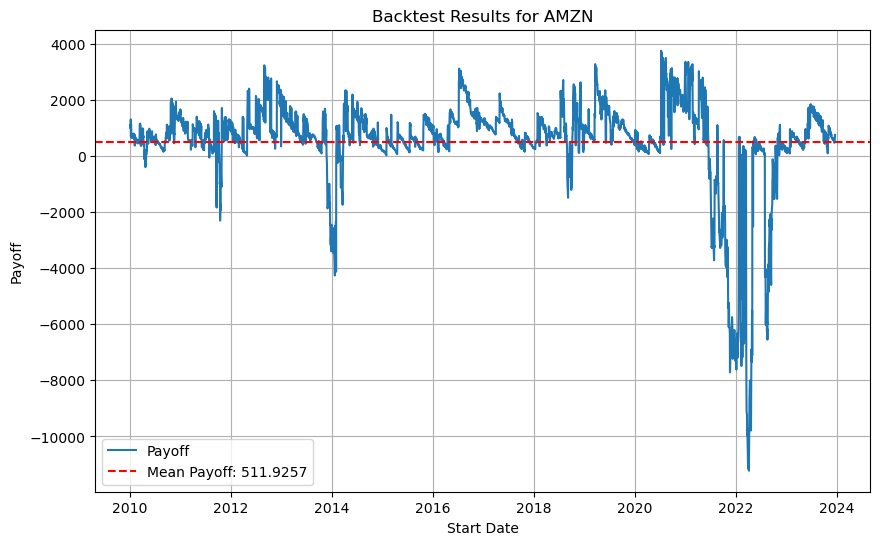

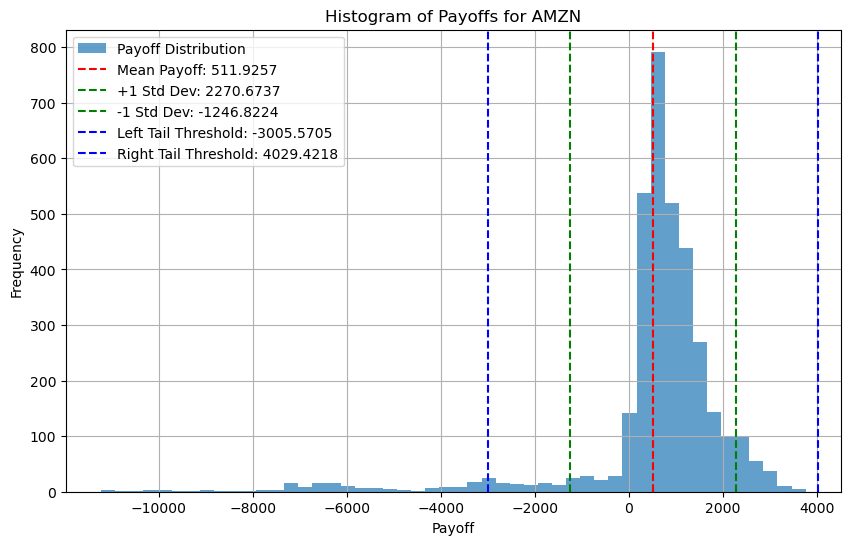

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to backtest the accumulator for a single asset
def backtest_accumulator(data, T, r, daily_shares):
    results = []
    num_steps = int(T * 252)  # Approximate number of business days in T years

    for start_idx in range(len(data) - num_steps):
        start_price = data[start_idx]
        adjustment_factor = 100 / start_price  # Adjust the product based on initial stock price
        strike = start_price * 0.89  # Dynamic strike price
        barrier = start_price * 1.15  # Dynamic barrier price

        prices = data[start_idx : start_idx + num_steps].values
        knocked_out = False
        payoff = 0

        for step, price in enumerate(prices):
            if price >= barrier:
                knocked_out = True
                break

            # Accumulate shares based on price relative to strike
            if price >= strike:
                payoff += adjustment_factor * daily_shares * (price - strike) * np.exp(-r * step / 252)
            else:
                payoff += adjustment_factor * 2 * daily_shares * (price - strike) * np.exp(-r * step / 252)

        results.append({
            "Start Date": data.index[start_idx],
            "Payoff": payoff,
            "Knocked Out": knocked_out
        })

    return pd.DataFrame(results)

# Download historical data
ticker = "AMZN"
start_date = "2010-01-01"
end_date = "2024-12-19"
data = yf.download(ticker, start=start_date, end=end_date, progress=False)["Close"]

# Drop missing values to align data
data = data.dropna()

# Parameters for the accumulator
T = 1  # Time to maturity in years
r = 0.043  # Risk-free rate
daily_shares = 1  # Shares accumulated daily

# Perform backtest
results = backtest_accumulator(data, T, r, daily_shares)

# Analyze results
mean_payoff = results["Payoff"].mean()
std_dev_payoff = results["Payoff"].std()
left_tail_threshold = mean_payoff - 2 * std_dev_payoff
right_tail_threshold = mean_payoff + 2 * std_dev_payoff
left_tail_count = (results["Payoff"] < left_tail_threshold).sum()
right_tail_count = (results["Payoff"] > right_tail_threshold).sum()
left_tail_percentage = left_tail_count / len(results) * 100
right_tail_percentage = right_tail_count / len(results) * 100

print(results.head())
print(f"Average Payoff: {mean_payoff:.4f}")
print(f"Standard Deviation of Payoff: {std_dev_payoff:.4f}")
print(f"Knockout Rate: {results['Knocked Out'].mean():.2%}")
print(f"Left Tail (< {left_tail_threshold:.2f}): {left_tail_count} occurrences ({left_tail_percentage:.2f}%)")
print(f"Right Tail (> {right_tail_threshold:.2f}): {right_tail_count} occurrences ({right_tail_percentage:.2f}%)")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results["Start Date"], results["Payoff"], label="Payoff")
plt.axhline(mean_payoff, color='r', linestyle='--', label=f"Mean Payoff: {mean_payoff:.4f}")
plt.xlabel("Start Date")
plt.ylabel("Payoff")
plt.title(f"Backtest Results for {ticker}")
plt.legend()
plt.grid(True)
plt.show()

# Plot histogram of payoffs
plt.figure(figsize=(10, 6))
plt.hist(results["Payoff"], bins=50, alpha=0.7, label="Payoff Distribution")
plt.axvline(mean_payoff, color='r', linestyle='--', label=f"Mean Payoff: {mean_payoff:.4f}")
plt.axvline(mean_payoff + std_dev_payoff, color='g', linestyle='--', label=f"+1 Std Dev: {mean_payoff + std_dev_payoff:.4f}")
plt.axvline(mean_payoff - std_dev_payoff, color='g', linestyle='--', label=f"-1 Std Dev: {mean_payoff - std_dev_payoff:.4f}")
plt.axvline(left_tail_threshold, color='b', linestyle='--', label=f"Left Tail Threshold: {left_tail_threshold:.4f}")
plt.axvline(right_tail_threshold, color='b', linestyle='--', label=f"Right Tail Threshold: {right_tail_threshold:.4f}")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.title(f"Histogram of Payoffs for {ticker}")
plt.legend()
plt.grid(True)
plt.show()

### 6. Basket Accumulator Pricing and Greeks: Monte Carlo Simulation

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Function to simulate the accumulator price for a basket of stocks
def simulate_basket_accumulator(S0, weights, strike, barrier, T, r, sigma, correlation_matrix, num_steps, daily_shares, random_numbers):
    dt = T / num_steps
    payoff_results = []
    knocked_out_count = 0

    # Cholesky decomposition of the correlation matrix
    L = np.linalg.cholesky(correlation_matrix)

    for rand_path in random_numbers:
        prices = np.array(S0)  # Initial prices for all stocks in the basket
        knocked_out = False
        payoff = 0

        for step, Z in enumerate(rand_path):
            correlated_Z = L @ Z

            # Simulate next stock prices using GBM
            prices = prices * np.exp((r - 0.5 * np.array(sigma)**2) * dt + np.array(sigma) * np.sqrt(dt) * correlated_Z)

            # Calculate weighted basket price
            basket_price = np.dot(weights, prices)

            # Check knock-out condition
            if basket_price >= barrier:
                knocked_out = True
                knocked_out_count += 1
                break

            # Accumulate shares based on price relative to strike
            if basket_price >= strike:
                payoff += daily_shares * (basket_price - strike) * np.exp(-r * step * dt)
            else:
                payoff += 2 * daily_shares * (basket_price - strike) * np.exp(-r * step * dt)

        payoff_results.append(payoff)

    # Calculate statistics
    mean_payoff = np.mean(payoff_results)
    std_dev = np.std(payoff_results)
    knock_out_rate = knocked_out_count / len(random_numbers)

    return mean_payoff, std_dev, knock_out_rate, payoff_results

# Confidence interval calculation
def calculate_confidence_interval(payoffs, confidence_level=0.95):
    sample_mean = np.mean(payoffs)
    sample_std_dev = np.std(payoffs, ddof=1)  # Sample standard deviation
    z_value = 1.96  # For 95% confidence interval
    margin_of_error = z_value * sample_std_dev / np.sqrt(len(payoffs))

    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error

    return sample_mean, sample_std_dev, (lower_bound, upper_bound)

# Numerical Greeks calculation
def calculate_greeks(S0, weights, strike, barrier, T, r, sigma, correlation_matrix, num_steps, daily_shares, random_numbers, epsilon=1e-4):
    # Delta: Sensitivity to initial stock prices
    deltas = []
    for i in range(len(S0)):
        S0_up = S0.copy()
        S0_down = S0.copy()
        S0_up[i] += epsilon
        S0_down[i] -= epsilon

        payoff_up, _, _, _ = simulate_basket_accumulator(S0_up, weights, strike, barrier, T, r, sigma, correlation_matrix, num_steps, daily_shares, random_numbers)
        payoff_down, _, _, _ = simulate_basket_accumulator(S0_down, weights, strike, barrier, T, r, sigma, correlation_matrix, num_steps, daily_shares, random_numbers)

        delta = (payoff_up - payoff_down) / (2 * epsilon)
        deltas.append(delta)

    # Vega: Sensitivity to volatility
    vegas = []
    for i in range(len(sigma)):
        sigma_up = sigma.copy()
        sigma_down = sigma.copy()
        sigma_up[i] += epsilon
        sigma_down[i] -= epsilon

        payoff_up, _, _, _ = simulate_basket_accumulator(S0, weights, strike, barrier, T, r, sigma_up, correlation_matrix, num_steps, daily_shares, random_numbers)
        payoff_down, _, _, _ = simulate_basket_accumulator(S0, weights, strike, barrier, T, r, sigma_down, correlation_matrix, num_steps, daily_shares, random_numbers)

        vega = (payoff_up - payoff_down) / (2 * epsilon)
        vegas.append(vega)

    return deltas, vegas


Basket Accumulator Mean Payoff: 1.7139
Standard Deviation: 8145.3927
Knock-Out Rate: 48.65%
95% Confidence Interval: (-48.77203803255499, 52.19980054697392)


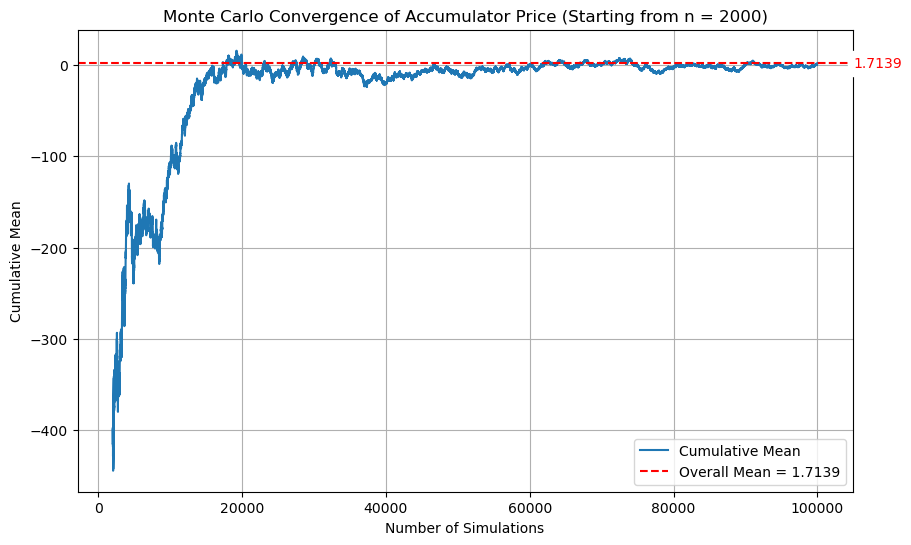

In [10]:
# Parameters for the simulation
S0 = [248.05, 220.52, 597.19]   # Example initial prices for AAPL, AMZN, META
weights = [1000 / price for price in S0]
weights = weights / np.sum(weights)  # Normalize weights
strike = np.dot(weights, S0) * 0.9018
barrier = np.dot(weights, S0) * 1.20
T = 1  # Time to maturity in years
r = 0.043  # Risk-free rate
sigma = [AMZN_vol, AAPL_vol, META_vol] # Example volatilities for AMZN, AAPL, META
correlation_matrix = np.array([[1.0, 0.619072, 0.591930],
                                [0.619072, 1.0, 0.613559],
                                [0.591930, 0.613559, 1.0]])
num_steps = 252  # Daily steps
num_simulations = 100000  # Number of simulations
daily_shares = 1  # Shares accumulated daily

# Generate random numbers
random_numbers = [np.random.normal(size=(num_steps, len(S0))) for _ in range(num_simulations)]

# Perform simulation
mean_payoff, std_dev, knock_out_rate, payoff_results = simulate_basket_accumulator(
    S0, weights, strike, barrier, T, r, sigma, correlation_matrix, num_steps, daily_shares, random_numbers
)

# Confidence interval
mean_price, std_dev_price, conf_interval = calculate_confidence_interval(payoff_results)

# Print results
print(f"Basket Accumulator Mean Payoff: {mean_payoff:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"Knock-Out Rate: {knock_out_rate:.2%}")
print(f"95% Confidence Interval: {conf_interval}")

# Plot convergence
check_convergence_from_n(payoff_results, start_n=2000)

In [11]:
# Calculate Greeks
deltas, vegas = calculate_greeks(S0, weights, strike, barrier, T, r, sigma, correlation_matrix, num_steps, daily_shares, random_numbers)

# Print Greeks
print("Deltas:", deltas)
print("Vegas:", vegas)

Deltas: [-72.25542352035097, -57.86685300083971, -0.4140777140115848]
Vegas: [-12577.06069451481, -13116.742381155753, -12836.354955458037]


### 7. Basket Accumulator: Historical Backtest

  Start Date       Payoff  Knocked Out
0 2012-05-18  1556.072055        False
1 2012-05-21  1804.760568        False
2 2012-05-22  2633.198529        False
3 2012-05-23  2117.048242        False
4 2012-05-24  2047.360980        False
Average Payoff: 882.8129
Standard Deviation of Payoff: 1764.5874
Knockout Rate: 84.39%
Left Tail (< -2646.36): 139 occurrences (5.20%)
Right Tail (> 4411.99): 0 occurrences (0.00%)


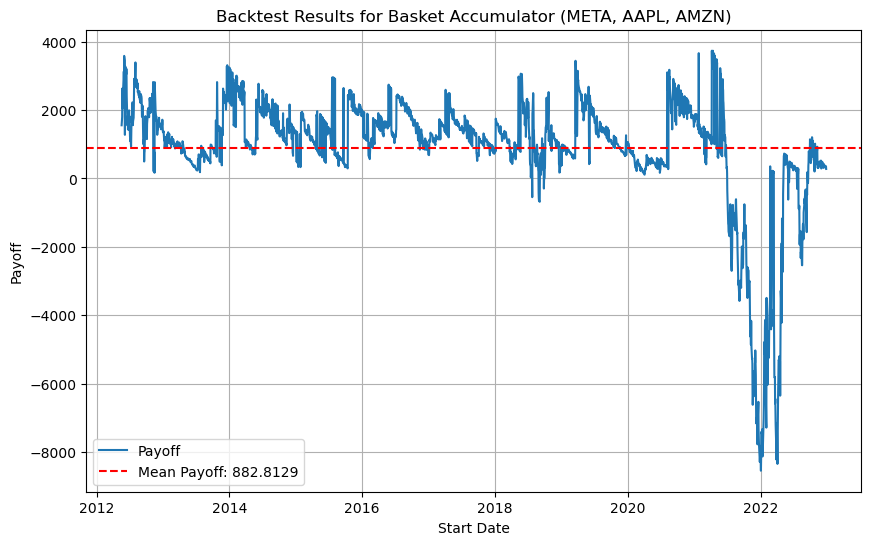

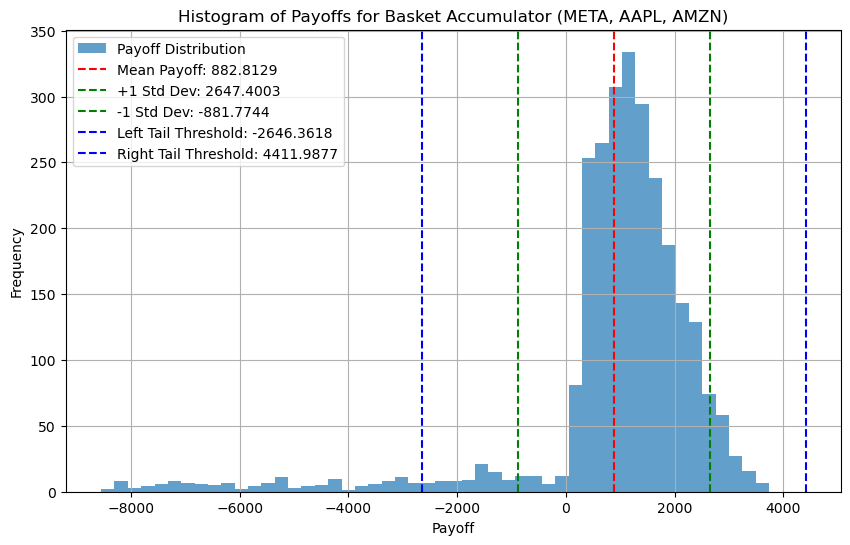

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to backtest the accumulator with a basket of assets
def backtest_basket_accumulator(data, weights, T, r, daily_shares):
    results = []
    num_steps = int(T * 252)  # Approximate number of business days in T years

    for start_idx in range(len(data) - num_steps):
        start_prices = data.iloc[start_idx].values
        basket_start_price = np.dot(start_prices, weights)
        adjustment_factor = 100 / basket_start_price
        strike = basket_start_price * 0.89
        barrier = basket_start_price * 1.15

        prices = data.iloc[start_idx : start_idx + num_steps].values
        basket_prices = np.dot(prices, weights)  # Weighted basket price
        knocked_out = False
        payoff = 0

        for step, basket_price in enumerate(basket_prices):
            if basket_price >= barrier:
                knocked_out = True
                break

            # Accumulate shares based on price relative to strike
            if basket_price >= strike:
                payoff += adjustment_factor * daily_shares * (basket_price - strike) * np.exp(-r * step / 252)
            else:
                payoff += adjustment_factor * 2 * daily_shares * (basket_price - strike) * np.exp(-r * step / 252)

        results.append({
            "Start Date": data.index[start_idx],
            "Payoff": payoff,
            "Knocked Out": knocked_out
        })

    return pd.DataFrame(results)

# Download historical data
tickers = ["META", "AAPL", "AMZN"]
start_date = "2010-01-01"
end_date = "2024-01-01"
data = yf.download(tickers, start=start_date, end=end_date, progress=False)["Close"]

# Drop missing values to align data
data = data.dropna()

# Calculate weights
initial_prices = data.iloc[0]
weights = [500 / price for price in initial_prices]
weights = weights / np.sum(weights)  # Normalize weights

# Parameters for the accumulator
T = 1  # Time to maturity in years
r = 0.05  # Risk-free rate
daily_shares = 1  # Shares accumulated daily

# Perform backtest
results = backtest_basket_accumulator(data, weights, T, r, daily_shares)

# Analyze results
mean_payoff = results["Payoff"].mean()
std_dev_payoff = results["Payoff"].std()
left_tail_threshold = mean_payoff - 2 * std_dev_payoff
right_tail_threshold = mean_payoff + 2 * std_dev_payoff
left_tail_count = (results["Payoff"] < left_tail_threshold).sum()
right_tail_count = (results["Payoff"] > right_tail_threshold).sum()
left_tail_percentage = left_tail_count / len(results) * 100
right_tail_percentage = right_tail_count / len(results) * 100

print(results.head())
print(f"Average Payoff: {mean_payoff:.4f}")
print(f"Standard Deviation of Payoff: {std_dev_payoff:.4f}")
print(f"Knockout Rate: {results['Knocked Out'].mean():.2%}")
print(f"Left Tail (< {left_tail_threshold:.2f}): {left_tail_count} occurrences ({left_tail_percentage:.2f}%)")
print(f"Right Tail (> {right_tail_threshold:.2f}): {right_tail_count} occurrences ({right_tail_percentage:.2f}%)")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results["Start Date"], results["Payoff"], label="Payoff")
plt.axhline(mean_payoff, color='r', linestyle='--', label=f"Mean Payoff: {mean_payoff:.4f}")
plt.xlabel("Start Date")
plt.ylabel("Payoff")
plt.title(f"Backtest Results for Basket Accumulator ({', '.join(tickers)})")
plt.legend()
plt.grid(True)
plt.show()

# Plot histogram of payoffs
plt.figure(figsize=(10, 6))
plt.hist(results["Payoff"], bins=50, alpha=0.7, label="Payoff Distribution")
plt.axvline(mean_payoff, color='r', linestyle='--', label=f"Mean Payoff: {mean_payoff:.4f}")
plt.axvline(mean_payoff + std_dev_payoff, color='g', linestyle='--', label=f"+1 Std Dev: {mean_payoff + std_dev_payoff:.4f}")
plt.axvline(mean_payoff - std_dev_payoff, color='g', linestyle='--', label=f"-1 Std Dev: {mean_payoff - std_dev_payoff:.4f}")
plt.axvline(left_tail_threshold, color='b', linestyle='--', label=f"Left Tail Threshold: {left_tail_threshold:.4f}")
plt.axvline(right_tail_threshold, color='b', linestyle='--', label=f"Right Tail Threshold: {right_tail_threshold:.4f}")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.title(f"Histogram of Payoffs for Basket Accumulator ({', '.join(tickers)})")
plt.legend()
plt.grid(True)
plt.show()


### 8. Basket Accumulator: Correlation Risk Analysis

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download historical data for 5 years
tickers = ["META", "AAPL", "AMZN"]
start_date = "2019-01-01"
end_date = "2024-01-01"
data = yf.download(tickers, start=start_date, end=end_date, progress=False)["Close"]

# Drop missing values to align data
data = data.dropna()

# Calculate daily returns
returns = data.pct_change().dropna()

# Compute the correlation matrix
correlation_matrix = returns.corr()

# Estimate correlation estimation standard error with confidence intervals
se_rho12 = (upper_bound - lower_bound).loc['AAPL','AMZN']/2/1.96
se_rho13 = (upper_bound - lower_bound).loc['AAPL','META']/2/1.96
se_rho23 = (upper_bound - lower_bound).loc['AMZN','META']/2/1.96
print(f'Estimated Correlation Standard Error \nse_rho12 = {se_rho12}\nse_rho13 = {se_rho13}\nse_rho23 = {se_rho23}')

rho12 = correlation_matrix.loc['AAPL','AMZN']
rho13 = correlation_matrix.loc['AAPL','META']
rho23 = correlation_matrix.loc['AMZN','META']

# Calculating Alphas
alpha1 = se_rho12/(1-rho12)
alpha2 = se_rho13/(1-rho13)
alpha3 = se_rho23/(1-rho23)
alpha = np.mean([alpha1, alpha2, alpha3])

# Modify the correlation matrix
modified_correlation_martix = correlation_matrix.copy()
modified_correlation_martix.loc['AAPL','AMZN'] = correlation_matrix.loc['AAPL','AMZN'] + alpha*(1-correlation_matrix.loc['AAPL','AMZN'])
modified_correlation_martix.loc['AAPL','META'] = correlation_matrix.loc['AAPL','META'] + alpha*(1-correlation_matrix.loc['AAPL','META'])
modified_correlation_martix.loc['AMZN','META'] = correlation_matrix.loc['AMZN','META'] + alpha*(1-correlation_matrix.loc['AMZN','META'])
modified_correlation_martix.loc['AMZN', 'AAPL'] = modified_correlation_martix.loc['AAPL','AMZN']
modified_correlation_martix.loc['META', 'AAPL'] = modified_correlation_martix.loc['AAPL','META']
modified_correlation_martix.loc['META', 'AMZN'] = modified_correlation_martix.loc['AMZN','META']

# Check the modified correlation martix and original correlation matrix
print(f'Original Correlation Matrix:{correlation_matrix}')
print(f'Modified Correlation Matrix:{modified_correlation_martix}')


Estimated Correlation Standard Error 
se_rho12 = 0.01741913795054547
se_rho13 = 0.018345616204158956
se_rho23 = 0.017610673793152273
Original Correlation Matrix:Ticker      AAPL      AMZN      META
Ticker                              
AAPL    1.000000  0.619072  0.591930
AMZN    0.619072  1.000000  0.613559
META    0.591930  0.613559  1.000000
Modified Correlation Matrix:Ticker      AAPL      AMZN      META
Ticker                              
AAPL    1.000000  0.636373  0.610464
AMZN    0.636373  1.000000  0.631111
META    0.610464  0.631111  1.000000


Original Basket Accumulator Mean Payoff: -24.1599
Original Standard Deviation: 8220.6709
Original Knock-Out Rate: 48.87%
Original 95% Confidence Interval: (-75.11244423333137, 26.792557100769255)


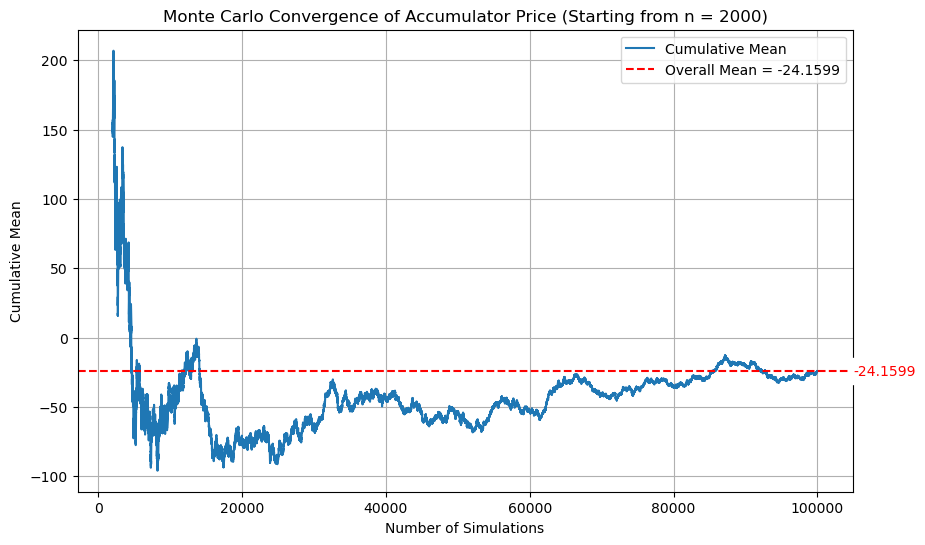

Original Basket Accumulator Mean Payoff: -115.5274
Original Standard Deviation: 8280.3623
Original Knock-Out Rate: 49.11%
Original 95% Confidence Interval: (-166.84990993082374, -64.20496163636379)


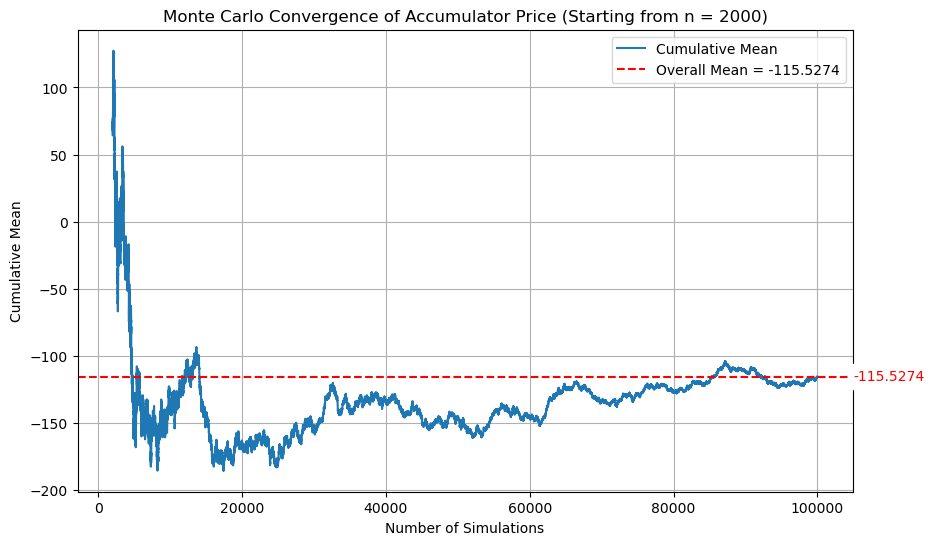

Delta V = -91.3674922173127


In [14]:
# Parameters for the simulation
S0 = [248.05, 220.52, 597.19]   # Example initial prices for AAPL, AMZN, META
weights = [1000 / price for price in S0]
weights = weights / np.sum(weights)  # Normalize weights
strike = np.dot(weights, S0) * 0.9018
barrier = np.dot(weights, S0) * 1.20
T = 1  # Time to maturity in years
r = 0.043  # Risk-free rate
sigma = [AMZN_vol, AAPL_vol, META_vol] # Example volatilities for AMZN, AAPL, META
num_steps = 252  # Daily steps
num_simulations = 100000  # Number of simulations
daily_shares = 1  # Shares accumulated daily

# Generate random numbers
random_numbers = [np.random.normal(size=(num_steps, len(S0))) for _ in range(num_simulations)]

# Perform simulation Original
mean_payoff_original, std_dev_original, knock_out_rate_original, payoff_results_original = simulate_basket_accumulator(
    S0, weights, strike, barrier, T, r, sigma, correlation_matrix, num_steps, daily_shares, random_numbers
)
mean_price_original, std_dev_price_original, conf_interval_original = calculate_confidence_interval(payoff_results_original)
print(f"Original Basket Accumulator Mean Payoff: {mean_payoff_original:.4f}")
print(f"Original Standard Deviation: {std_dev_original:.4f}")
print(f"Original Knock-Out Rate: {knock_out_rate_original:.2%}")
print(f"Original 95% Confidence Interval: {conf_interval_original}")
check_convergence_from_n(payoff_results_original, start_n=2000)


# Perform simulation New
mean_payoff_new, std_dev_new, knock_out_rate_new, payoff_results_new = simulate_basket_accumulator(
    S0, weights, strike, barrier, T, r, sigma, modified_correlation_martix, num_steps, daily_shares, random_numbers
)
mean_price_new, std_dev_price_new, conf_interval_new = calculate_confidence_interval(payoff_results_new)
print(f"Original Basket Accumulator Mean Payoff: {mean_payoff_new:.4f}")
print(f"Original Standard Deviation: {std_dev_new:.4f}")
print(f"Original Knock-Out Rate: {knock_out_rate_new:.2%}")
print(f"Original 95% Confidence Interval: {conf_interval_new}")
check_convergence_from_n(payoff_results_new, start_n=2000)

print(f'Delta V = {mean_price_new - mean_payoff_original}')

In [15]:
print(f'Delta V = {mean_price_new - mean_payoff_original}')

Delta V = -91.3674922173127
